# Deep Learning

## HW3- problem 2 - Knowledge Distillation

1.   Full Name: Alireza Maleki
2.   Student Number: 401210956

In [1]:
import tensorflow as tf
from keras import callbacks
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
from keras.datasets import cifar10
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import warnings
import imageio
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.layers import Dense, Input, GlobalAvgPool2D, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from tensorflow.keras.models import Sequential, Model

In [2]:
# load data
ds = cifar10.load_data();


d_train = tf.data.Dataset.from_tensor_slices(((ds[0][0]/255)-.5, to_categorical(ds[0][1])))
d_valid = tf.data.Dataset.from_tensor_slices(((ds[1][0]/255)-.5, to_categorical(ds[1][1])))

dataSample = ds[0][0][0]
labelSample = str(ds[0][1][0][0])

sh = dataSample.shape

del ds

170498071/170498071 [==============================] - 13s 0us/step


PIL img size (32, 32, 3)
**********************

sample data:


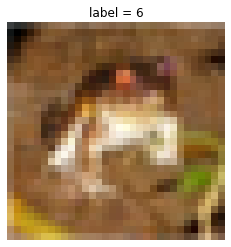

In [ ]:
print('PIL img size', dataSample.shape)
print('**********************')
print('\nsample data:')
plt.imshow(dataSample)
plt.axis('off')
plt.title('label = ' + labelSample)
plt.show()



In [ ]:
ResModel = ResNet50(input_shape= sh, include_top=False)
ResModel.trainable = False

baseModel = Sequential([ResModel, GlobalAvgPool2D()])

baseModel.add(tf.keras.layers.Flatten())
baseModel.add(tf.keras.layers.BatchNormalization())
baseModel.add(tf.keras.layers.Dense(1028, activation='relu'))
baseModel.add(tf.keras.layers.Dense(512, activation='relu'))
baseModel.add(tf.keras.layers.Dropout(0.5))
baseModel.add(tf.keras.layers.Dense(10, activation='softmax',name="outputL"))

baseModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 1028)              2106372   
                                                                 
 dense_4 (Dense)             (None, 512)              

In [ ]:
baseModel.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='categorical_crossentropy', metrics=['accuracy'])

## Stop training when a monitored metric has stopped improving.
earlyStop = callbacks.EarlyStopping( patience=4, verbose=1, restore_best_weights=True, min_delta=1e-4)

## Reduce learning rate when a metric has stopped improving.
redLearnRate = callbacks.ReduceLROnPlateau(patience=2, verbose=1)


baseResult = baseModel.fit(
    d_train.shuffle(512).batch(64),
    validation_data=d_valid.batch(512),
    epochs=30, batch_size= 64,
    callbacks= [redLearnRate, earlyStop])

baseModel.save('hw3-p2-1.h5')

Epoch 1/30
782/782 [==============================] - 18s 18ms/step - loss: 1.8057 - accuracy: 0.3577 - val_loss: 1.5910 - val_accuracy: 0.4366 - lr: 1.0000e-04
Epoch 2/30
782/782 [==============================] - 14s 18ms/step - loss: 1.5996 - accuracy: 0.4344 - val_loss: 1.5008 - val_accuracy: 0.4737 - lr: 1.0000e-04
Epoch 3/30
782/782 [==============================] - 14s 18ms/step - loss: 1.5183 - accuracy: 0.4667 - val_loss: 1.4449 - val_accuracy: 0.4907 - lr: 1.0000e-04
Epoch 4/30
782/782 [==============================] - 14s 17ms/step - loss: 1.4698 - accuracy: 0.4813 - val_loss: 1.4171 - val_accuracy: 0.5020 - lr: 1.0000e-04
Epoch 5/30
782/782 [==============================] - 14s 17ms/step - loss: 1.4282 - accuracy: 0.4976 - val_loss: 1.3863 - val_accuracy: 0.5120 - lr: 1.0000e-04
Epoch 6/30
782/782 [==============================] - 14s 18ms/step - loss: 1.3937 - accuracy: 0.5120 - val_loss: 1.3646 - val_accuracy: 0.5215 - lr: 1.0000e-04
Epoch 7/30
782/782 [==============

In [11]:
## Plot result
def resultPlotter(result):
  fig, ax = plt.subplots(1,2);
  fig.set_size_inches(14, 8);
  fig.suptitle("Model Result")

  ax[0].set_ylabel('Base Loss')
  ax[0].plot(result.history['loss'], label='train loss')
  ax[0].plot(result.history['val_loss'], label='train loss')
  ax[0].legend(loc='upper right')

  ax[1].plot(result.history['accuracy'], label='train acc')
  ax[1].plot(result.history['val_accuracy'], label='valid acc')
  ax[1].set_ylabel('Base Accuracy')
  ax[1].legend(loc='upper left')

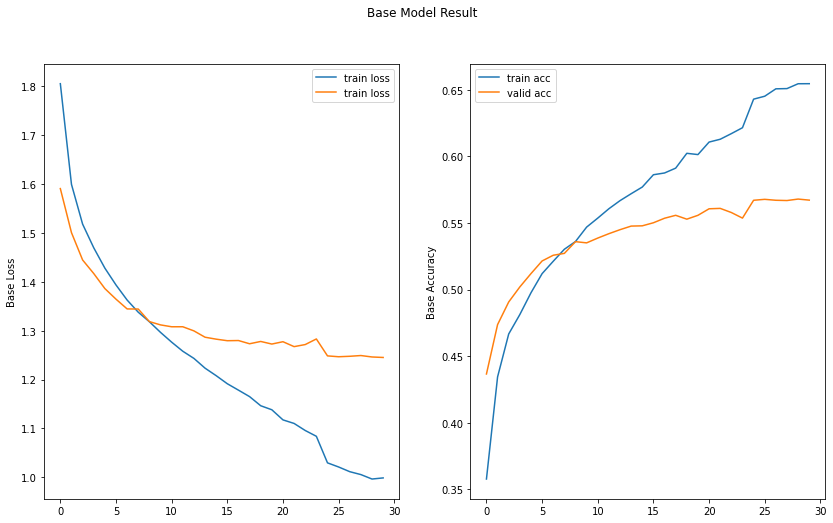

In [ ]:
resultPlotter(baseResult)

Flat model does not have a good accuracy and is incompatible with the data.

## RESNET18

Studet Model

https://www.kaggle.com/code/songrise/implementing-resnet-18-using-keras/notebook

![](https://intellabs.github.io/distiller/imgs/knowledge_distillation.png)

In [5]:


class ResnetBlock(Model):

    def __init__(self, channels: int, down_sample=False):
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer="he_normal")
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer="he_normal")
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer="he_normal", padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out





In [6]:
class Distiller(Model):
    def __init__(self, student, teacher, activation):
        super().__init__()
        self.teacher = teacher
        self.student = student
        self.activation = activation

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=10,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student.compile(optimizer=optimizer, metrics=metrics, loss=student_loss_fn)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                self.activation(teacher_predictions / self.temperature, axis=1),
                self.activation(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss, "loss": loss}
        )
        return results

    def test_step(self, data):
        x, y = data
        teacher_predictions = self.teacher(x, training=False)
        student_predictions = self.student(x, training=False)
        
        student_loss = self.student_loss_fn(y, student_predictions)
        distillation_loss = self.distillation_loss_fn(
            self.activation(teacher_predictions / self.temperature, axis=1),
            self.activation(student_predictions / self.temperature, axis=1),
        )
        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss, "loss": loss}
        )
        return results
    
    def call(self, x):
        return self.student(x)

## Train student beside teacher

In [ ]:
student_model = ResNet18(10)

distiller = Distiller(student_model, baseModel, tf.nn.softmax)
distiller.compile(
    optimizer= tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
    student_loss_fn= tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn= tf.keras.losses.KLDivergence(),
    alpha=0.7,
    temperature=100,
)

distillationResult = distiller.fit(
    d_train.shuffle(1024).batch(64), 
    validation_data=d_valid.batch(512),
    epochs=30, callbacks=[redLearnRate, earlyStop], batch_size=64
)


Epoch 1/30
782/782 [==============================] - 35s 40ms/step - accuracy: 0.4885 - student_loss: 1.4583 - distillation_loss: 1.2539e-06 - loss: 1.0208 - val_accuracy: 0.5871 - val_student_loss: 1.3818 - val_distillation_loss: 1.1696e-06 - val_loss: 0.9672 - lr: 0.0010
Epoch 2/30
782/782 [==============================] - 30s 38ms/step - accuracy: 0.6352 - student_loss: 1.0322 - distillation_loss: 1.0088e-06 - loss: 0.7225 - val_accuracy: 0.6512 - val_student_loss: 1.1114 - val_distillation_loss: 1.3615e-06 - val_loss: 0.7779 - lr: 0.0010
Epoch 3/30
782/782 [==============================] - 30s 38ms/step - accuracy: 0.7063 - student_loss: 0.8386 - distillation_loss: 1.0368e-06 - loss: 0.5870 - val_accuracy: 0.6763 - val_student_loss: 1.0163 - val_distillation_loss: 1.3206e-06 - val_loss: 0.7114 - lr: 0.0010
Epoch 4/30
782/782 [==============================] - 30s 38ms/step - accuracy: 0.7528 - student_loss: 0.7084 - distillation_loss: 1.1259e-06 - loss: 0.4959 - val_accuracy: 0.

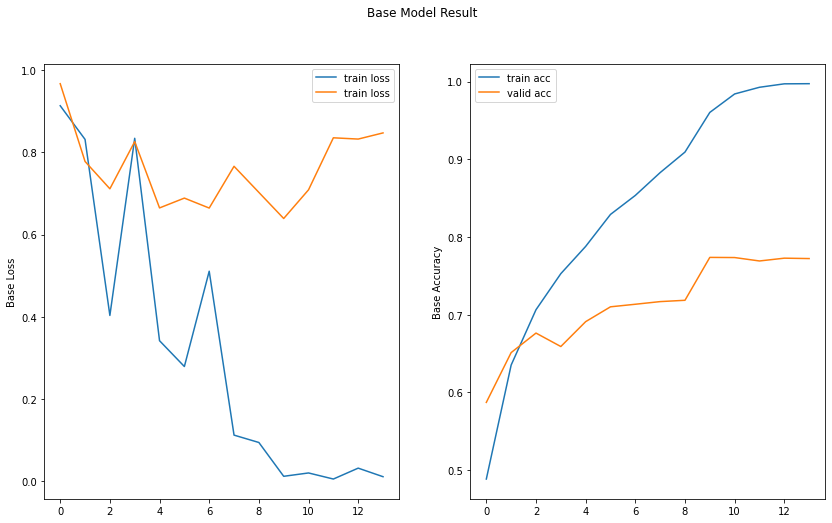

In [ ]:
resultPlotter(distillationResult)

Student accuracy is less than the teacher accuracy, because it is smaller. But with the teacher model co-learning, the studen gets better result.

## Solo Model

In [ ]:
student_model_solo = ResNet18(10)

student_model_solo.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='categorical_crossentropy', metrics=['accuracy'])

soloResult = student_model_solo.fit(
    d_train.shuffle(1024).batch(64),
    validation_data=d_valid.batch(512),
    epochs=20, batch_size= 64,
    callbacks= [redLearnRate, earlyStop])


Epoch 1/20
782/782 [==============================] - 22s 25ms/step - loss: 1.7963 - accuracy: 0.3817 - val_loss: 1.5102 - val_accuracy: 0.4633 - lr: 1.0000e-04
Epoch 2/20
782/782 [==============================] - 21s 27ms/step - loss: 1.3021 - accuracy: 0.5358 - val_loss: 1.4223 - val_accuracy: 0.5033 - lr: 1.0000e-04
Epoch 3/20
782/782 [==============================] - 20s 26ms/step - loss: 1.0368 - accuracy: 0.6327 - val_loss: 1.3918 - val_accuracy: 0.5246 - lr: 1.0000e-04
Epoch 4/20
782/782 [==============================] - 19s 24ms/step - loss: 0.8024 - accuracy: 0.7174 - val_loss: 1.4665 - val_accuracy: 0.5353 - lr: 1.0000e-04
Epoch 5/20
781/782 [============================>.] - ETA: 0s - loss: 0.5803 - accuracy: 0.7960
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
782/782 [==============================] - 19s 24ms/step - loss: 0.5803 - accuracy: 0.7959 - val_loss: 1.6656 - val_accuracy: 0.5287 - lr: 1.0000e-04
Epoch 6/20
782/782 [==============

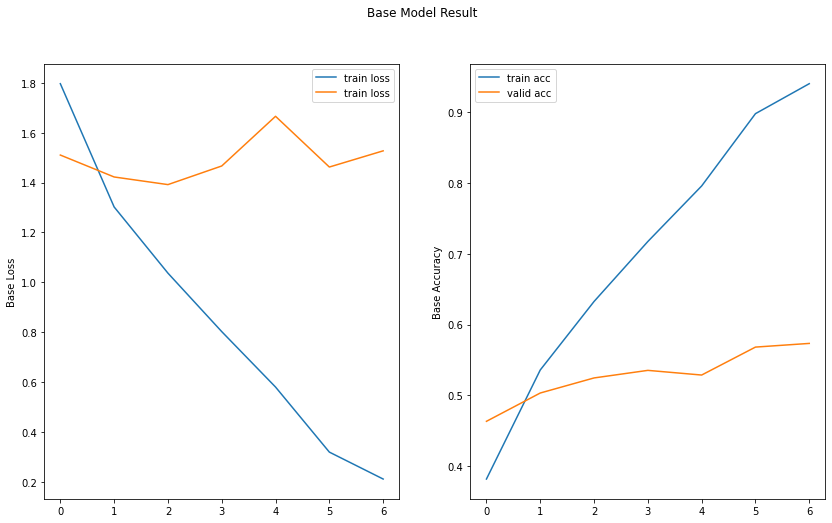

In [ ]:
resultPlotter(soloResult)

As we can see, the solo model has not a good accuracy without the teacher model.

## Fine Tune

In [7]:
ResModel = ResNet50(input_shape= sh, include_top=False)
ResModel.trainable = True

baseModel = Sequential([ResModel, GlobalAvgPool2D()])

baseModel.add(tf.keras.layers.Flatten())
baseModel.add(tf.keras.layers.BatchNormalization())
baseModel.add(tf.keras.layers.Dense(512, activation='relu'))
baseModel.add(tf.keras.layers.Dropout(0.5))
baseModel.add(tf.keras.layers.Dense(128, activation='relu'))
baseModel.add(tf.keras.layers.Dropout(0.5))
baseModel.add(tf.keras.layers.Dense(10, activation='softmax',name="outputL"))


baseModel.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='categorical_crossentropy', metrics=['accuracy'])

baseResult = baseModel.fit(
    d_train.shuffle(1024).batch(64),
    validation_data=d_valid.batch(512),
    epochs=20, batch_size= 64,
    callbacks= [redLearnRate, earlyStop])

baseModel.save('hw3-p2-2.h5')

94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/20
782/782 [==============================] - 54s 52ms/step - loss: 2.0154 - accuracy: 0.3534 - val_loss: 2.2837 - val_accuracy: 0.2038 - lr: 1.0000e-04
Epoch 2/20
782/782 [==============================] - 37s 48ms/step - loss: 1.1151 - accuracy: 0.6375 - val_loss: 0.7998 - val_accuracy: 0.7345 - lr: 1.0000e-04
Epoch 3/20
782/782 [==============================] - 37s 47ms/step - loss: 0.8441 - accuracy: 0.7342 - val_loss: 0.6882 - val_accuracy: 0.7759 - lr: 1.0000e-04
Epoch 4/20
782/782 [==============================] - 36s 46ms/step - loss: 0.6732 - accuracy: 0.7907 - val_loss: 0.6524 - val_accuracy: 0.7851 - lr: 1.0000e-04
Epoch 5/20
782/782 [==============================] - 36s 46ms/step - loss: 0.5620 - accuracy: 0.8266 - val_loss: 0.6332 - val_accuracy: 0.7955 - lr: 1.0000e-04
Epoch 6/20
782/782 [==============================] - 36s 46ms/step - loss: 0.4664 - accuracy: 0.8576 - val_loss: 0.6228 - val_acc

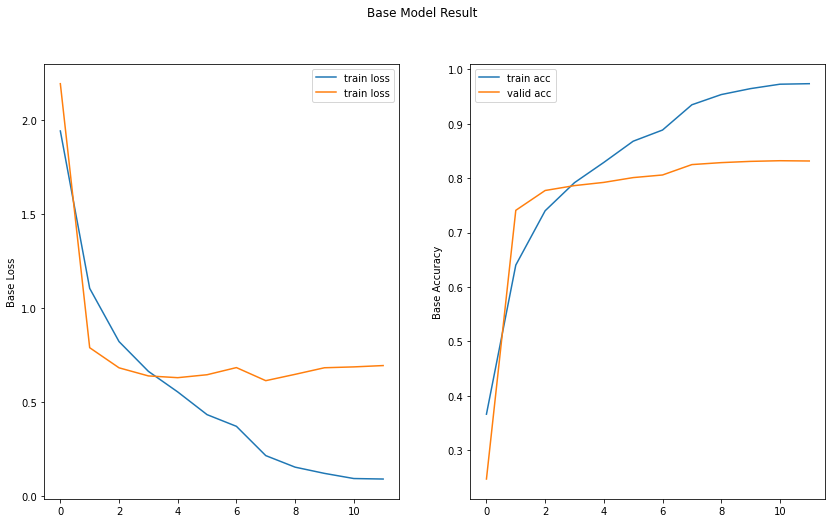

In [ ]:
resultPlotter(baseResult)

Because of the deep weights update, the base-model accuracy increase.

In [8]:
student_model = ResNet18(10)

distiller = Distiller(student_model, baseModel, tf.nn.softmax)
distiller.compile(
    optimizer= tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
    student_loss_fn= tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn= tf.keras.losses.KLDivergence(),
    alpha=0.7,
    temperature=100,
)

distillationResult = distiller.fit(
    d_train.shuffle(1024).batch(64), 
    validation_data=d_valid.batch(32),
    epochs=30, callbacks=[], batch_size=64
)

Epoch 1/30


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


782/782 [==============================] - 39s 45ms/step - accuracy: 0.4870 - student_loss: 1.4452 - distillation_loss: 2.6362e-06 - loss: 1.0117 - val_accuracy: 0.5422 - val_student_loss: 1.4321 - val_distillation_loss: 2.2564e-06 - val_loss: 1.0025
Epoch 2/30
782/782 [==============================] - 33s 42ms/step - accuracy: 0.6330 - student_loss: 1.0335 - distillation_loss: 1.8685e-06 - loss: 0.7235 - val_accuracy: 0.6418 - val_student_loss: 1.0596 - val_distillation_loss: 1.7764e-06 - val_loss: 0.7417
Epoch 3/30
782/782 [==============================] - 33s 42ms/step - accuracy: 0.7054 - student_loss: 0.8456 - distillation_loss: 1.5097e-06 - loss: 0.5919 - val_accuracy: 0.6659 - val_student_loss: 0.8074 - val_distillation_loss: 1.9594e-06 - val_loss: 0.5652
Epoch 4/30
782/782 [==============================] - 33s 42ms/step - accuracy: 0.7525 - student_loss: 0.7122 - distillation_loss: 1.2801e-06 - loss: 0.4985 - val_accuracy: 0.6645 - val_student_loss: 0.9982 - val_distillation

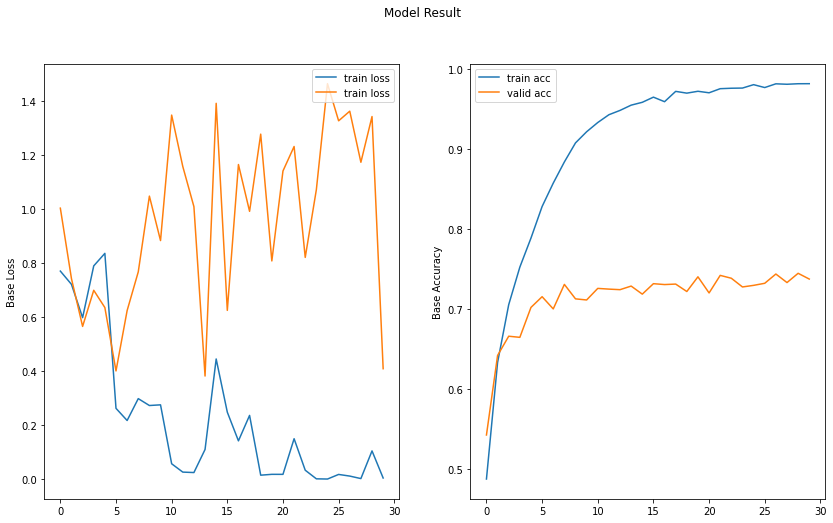

In [12]:
resultPlotter(distillationResult)

The Student model is smaller than the teacher model, and it limits the model accuracy. If we train the teacher's deep weights, it converges to the deterministic model and the randomness decrease. Also, the teacher model and the student model get more far from each other and the teacher model cannot teach the student properly.